In [2]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/datasets/global-temp/master/data/monthly.csv \
    -O /tmp/global-temp.csv


--2020-04-08 08:56:49--  https://raw.githubusercontent.com/datasets/global-temp/master/data/monthly.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 69029 (67K) [text/plain]
Saving to: ‘/tmp/global-temp.csv’

/tmp/global-temp.cs 100%[===================>]  67.41K  --.-KB/s    in 0.009s  

2020-04-08 08:56:49 (7.67 MB/s) - ‘/tmp/global-temp.csv’ saved [69029/69029]



In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Temperature")
    plt.grid(True)

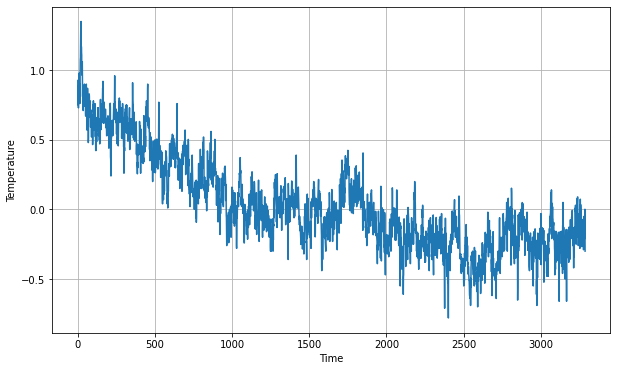

In [4]:
import csv
time_step = []
temps = []

with open('/tmp/global-temp.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[2]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time,series)

In [0]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [21]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 30
batch_size = 150
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
17/17 [==============================] - 0s 15ms/step - loss: 0.7008 - mae: 1.0081 - lr: 1.0000e-08
Epoch 2/100
17/17 [==============================] - 0s 18ms/step - loss: 0.6242 - mae: 0.9065 - lr: 1.1220e-08
Epoch 3/100
17/17 [==============================] - 0s 18ms/step - loss: 0.5563 - mae: 0.8425 - lr: 1.2589e-08
Epoch 4/100
17/17 [==============================] - 0s 17ms/step - loss: 0.5149 - mae: 0.8176 - lr: 1.4125e-08
Epoch 5/100
17/17 [==============================] - 0s 18ms/step - loss: 0.4848 - mae: 0.8094 - lr: 1.5849e-08
Epoch 6/100
17/17 [==============================] - 0s 16ms/step - loss: 0.4617 - mae: 0.8002 - lr: 1.7783e-08
Epoch 7/100
17/17 [==============================] - 0s 17ms/step - loss: 0.4438 - mae: 0.7859 - lr: 1.9953e-08
Epoch 8/100
17/17 [==============================] - 0s 14ms/step - loss: 0.4291 - mae: 0.7670 - lr: 2.2387e-08
Ep

(1e-08, 0.0001, 0.0, 60.0)

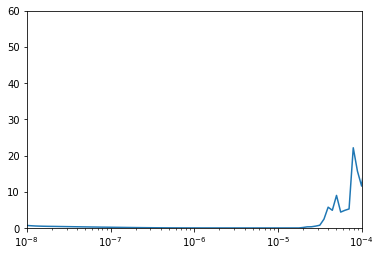

In [22]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [23]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=30, batch_size=150, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,strides=1, padding="causal",activation="relu",input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=7.9433e-06, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
17/17 [==============================] - 0s 12ms/step - loss: 0.4774 - mae: 0.8740
Epoch 2/150
17/17 [==============================] - 0s 15ms/step - loss: 0.0718 - mae: 0.2977
Epoch 3/150
17/17 [==============================] - 0s 13ms/step - loss: 0.0332 - mae: 0.1983
Epoch 4/150
17/17 [==============================] - 0s 17ms/step - loss: 0.0309 - mae: 0.1903
Epoch 5/150
17/17 [==============================] - 0s 16ms/step - loss: 0.0261 - mae: 0.1729
Epoch 6/150
17/17 [==============================] - 0s 14ms/step - loss: 0.0214 - mae: 0.1544
Epoch 7/150
17/17 [==============================] - 0s 16ms/step - loss: 0.0213 - mae: 0.1552
Epoch 8/150
17/17 [==============================] - 0s 16ms/step - loss: 0.0222 - mae: 0.1618
Epoch 9/150
17/17 [==============================] - 0s 16ms/step - loss: 0.0187 - mae: 0.1462
Epoch 10/150
17/17 [==============================] - 0s 17ms/step - loss: 0.0175 - mae: 0.1391
Epoch 11/150
17/17 [=============================

In [0]:
forecasts = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = forecasts[split_time - window_size:-1, -1, 0]

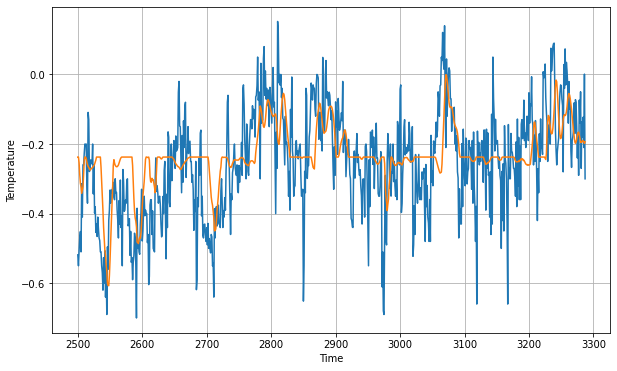

In [25]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [26]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

0.10355751